# Schottky Analysis Tutorial
### \[Work in Progress!\]

By George Hudson-Chang, [github.com/gwgwhc](https://github.com/gwgwhc)

Welcome my tutorial on analysing Schottky frequency signals. Hopefully by the end of this you will have no problem processing raw schottky data, creating a frequency spectrum, identifying peaks and performing particle identification. Basic knowledge of python is assumed but I'll try to include assistance for beginners.

## Installation

First, we will need to download all of our tools.

Our main requirements are a python installation and a some packages from github. Most Linux distributions and Mac come pre-installed with python, but if you don't have it, you can use the package manager mamba.

If you already have python, iqtools requires version 3.10 so please follow the installation instructions below if you don't know how to install that specific version.

### Installing Python
You can download the [miniforge installer here](https://github.com/conda-forge/miniforge) which has installation instructions if you scroll down the page. We can see if everything worked by typing `mamba info` in console. 

It's common practice to create a new environment to neatly contain the packages. In your console type:
>`mamba create -n my_env`

You can replace `my_env` with the environment name of your choice if you wish. Then we will enter the new environment with

>`mamba activate my_env` 

Remember you must be in this environment to use the packages we will install! 

Next we can install python along with the packages we need: git, root and pyqt. Luckily for you, it's only one line.
>`mamba install python=3.10 root pyqt git`

Note: iqtools does not work on python 3.11 or above due to dependencies.

### Downloading github packages
From github we will need iqtools for our spectrum analysis, rionid for particle identification (PID) and their dependencies. 

mac/linux users can follow the short tutorial from @Xaratustrah found here: [analysistools.md](https://gist.github.com/xaratustrah/978a62cbd7f3f0ea37dc20529cdb7caf).

If you're too lazy too even follow the link: in a bash terminal (type bash in your current terminal), create a new bash file, e.g. `analysistools_installer.sh`, and inside paste the following:

<pre>
mkdir /tmp/analysistools && cd "$_"
curl -LkSs https://api.github.com/repos/xaratustrah/iqtools/tarball | tar xz -C ./
curl -LkSs https://api.github.com/repos/xaratustrah/barion/tarball | tar xz -C ./
curl -LkSs https://api.github.com/repos/gwgwhc/lisereader/tarball | tar xz -C ./
curl -LkSs https://api.github.com/repos/DFreireF/rionid/tarball | tar xz -C ./
find . -maxdepth 1 -type d -exec bash -c "cd '{}' && pip install -r requirements.txt" \;
find . -maxdepth 1 -type d -exec bash -c "cd '{}' && pip install ." \;
pip install loguru

rm -rf /tmp/analysistools
</pre>

then simply execute this file using

`sh analysistools.sh`

This should install all of the dependencies. If you are on windows or this doesn't work using mac, you can instead clone the repositories for [iqtools](https://github.com/xaratustrah/iqtools), [rionid](https://github.com/DFreireF/rionid), [barion](https://github.com/xaratustrah/barion) and [lisereader](https://github.com/gwgwhc/lisereader) using `git clone [repository url]`. Then navigate to the top of each new directory and run

`pip install -r requirements.txt`
(if it has requirements)

`pip install .`




## Starting the analysis

If you don't already have a cuppa beside you, this is your chance to fetch a beverage of choice. Please respect any rules pertaining to alcohol consumption during office hours.

Create a new file for your analysis. 

`schottky_analysis.ipynb`

I recommend using python notebooks, but if you're not comfortable with those just create a normal `.py` file.

First import the modules we need. If you're missing any don't be afraid to `mamba install` the missing module.

In [1]:
import numpy as np
from iqtools import *
import matplotlib.pyplot as plt
import scipy.signal
from lmfit import Model
from os import listdir
from colorama import Fore, Back
from scipy.constants import c

%matplotlib inline


### Importing Data
We'll begin by importing the raw data. `listdir` from `os` can be used to create a list of files in our directory.

Here there is only one file so the situation is simple, but this will be useful with a directory of many files.

In [25]:
file_list = listdir("data")
file_list  # typing a variable in a jupyter notebook prints it

['example.tiq', '.DS_Store', 'example.csv', 'example_data.csv']

In [3]:
# import data
current_file_index = 0  # choose the file from the file_list
rawdata = f"data/{file_list[current_file_index]}"

The raw data is placed into an object we are going to call `iqdata`. The object has built in functions that we can perform on it and hence on the data.

 Below, I find the centre frequency, measurement time and sampling rate by using the functions from iqtools.

In [4]:
iqdata = get_iq_object(rawdata)
# print some useful information
print(f"centre frequency: {iqdata.center / 1e6} MHz")
print(f"measurement time: {iqdata.nsamples_total / iqdata.fs} sec")
print(f"sampling rate: {iqdata.fs / 1e6} MHz")

centre frequency: 244.53 MHz
measurement time: 60.0 sec
sampling rate: 3.125 MHz


### Reading the data
`lframes` is the length of the frames. It tells us the number of bins we will split our frequency range into. 

We can see the length of each bin in frequency space by dividing the sampling frequency by the frame length, $f_\text{s}/\text{lframes}$.

The reciprocal of this number will also tell us the size of each bin in the time domain.

In [5]:
# set params & read data
lframes = int(2e4)  # number of bins in freq.
freq_bin_size = iqdata.fs / lframes
t_bin_size = 1 / freq_bin_size
print(f"freq bin size: {freq_bin_size} Hz")
print(f"time bin size: {t_bin_size * 1e3} ms")

freq bin size: 156.25 Hz
time bin size: 6.4 ms


Next, we have to decide on `nframes`, the amount frames we want - essentially how long our data will be in units of the time bins we calculated above. It's useful to think about this in seconds. For example, if we wanted 5 seconds of data, we just divide 5 by the time bin size (in seconds) to get the number of bins. This must be an integer since we can't have a fraction of a frame.

We can also specify an amount of frames to skip, `sframes`. This can also be in time. In the example below I skipped past 2 seconds. You may want to do this to miss out blank or irregular data at the start of the file.

In [6]:
nframes = int(5 / (t_bin_size))  # number of time bins
sframes = int(2 / t_bin_size)  # number of time bins to skip
iqdata.read(nframes, lframes, sframes)

### Operating on the Data
The final step is to fourier transform the data to see the power spectrogram. Advanced users may wish to set the window function and spectral density estimation technique. For us, a Hamming window and the multitaper method are appropriate.

In [7]:
# get power spectrum
iqdata.window = "hamming"
iqdata.method = "mtm"
xx, yy, zz = iqdata.get_power_spectrogram(nframes=nframes, lframes=lframes)
# xx = frequency
# yy = time
# zz = power

Now we can finally take a look at our spectrum. The built-in `plot_spectrogram` function is a quick way to check everything looks similar to what you expect, though of course you can plot with whatever you fancy.

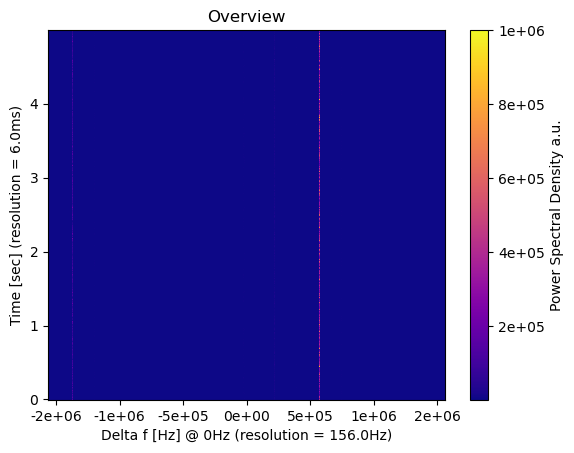

In [8]:
plot_spectrogram(
    xx,
    yy,
    zz,
    title="Overview",
    cmap="plasma",
    decimal_place=0,  # Too many digits for me
)

Here we have a rough overview of the data. Since it hasn't been averaged, not much is visible.

To average the data I have built a simple function, but feel free to make your own.

In [9]:
def time_average(
    freq, t, pwr, t_start, t_stop, dbm=True
):  # get 1d averaged frequency and power information from iqtools' 2d mesh
    # get linear time from time mesh
    time = np.average(t, axis=1)

    # cut time array to specified window
    time_cut = [x for x in np.average(t, axis=1) if t_start < x < t_stop]

    # find indices (location) of t_start and t_stop values
    start_index, end_index = (
        np.where(time == np.min(time_cut))[0][0],
        np.where(time == np.max(time_cut))[0][0] + 1,
    )

    # get avg freq and power within the time window
    freq_avg = np.average(freq[start_index:end_index], axis=0)

    # outputs as dbm data if dbm=True
    if dbm == True:
        pwr_avg = iqdata.get_dbm(np.average(pwr[start_index:end_index], axis=0))
    else:
        pwr_avg = np.average(pwr[start_index:end_index], axis=0)
    return freq_avg, pwr_avg

Now we can use it to average our data over the whole time frame:

In [10]:
# get averaged spectrogram
freq_avg, pwr_avg = time_average(xx, yy, zz, 0, 60, dbm=False)

### Using RIONID
**!!! Ignore this section if you don't need to perform PID !!!**

The next step is performing a particle identification with the help of rionid. 

Currently, our data is centred on zero, however for rionid it should be at the real frequency. We can achieve this easily by the central frequency from iqtools.

The average power is also scaled for rionid, +1 as a workaround for a bug.

In [11]:
# format data for rionid
freq_avg_out = freq_avg + iqdata.center
pwr_avg_out = pwr_avg * 1e5 + 1

Finally, the data should be formatted for rionid - two columns containing frequency and power respectively with a pipe delimiter. If you're not sure what the structure of your data looks like, use the `.shape` command liberally.

e.g. `freq_avg_out.shape`

In [12]:
# output averaged spectrogram for rionid PID
out_array = np.resize(np.concatenate((freq_avg_out, pwr_avg_out)), (len(freq_avg), 2))
np.savetxt(f"data/{file_list[current_file_index][0:-4]}.csv", out_array, delimiter="|")

### \[Will add section here on using rionid!\]

### Identifying and Fitting Peaks
Now we are ready to identify our peaks which should correlate to our isotopes. I'm changing the units of my power data to dBm (decibel milliwatts). This is a logarithmic scale so it will allow us to see the data more easily.

In [13]:
pwr_avg_dbm = iqdata.get_dbm(pwr_avg)

I'm using the `scipy.signal.find_peaks()` function to identify my peaks, though there are many different ways to do this in python.

I found that the prominence parameter is the most important one to mess with. You may want to change this depending on how sensitive you find the algorithm.

In [14]:
# find peaks
peaks = scipy.signal.find_peaks(
    pwr_avg_dbm,
    height=-35,  # min height, required for height output
    prominence=8,
)  # most important param.
# returns array with 2 elements, peak_bins is indices of peaks and
# peaks[1] is the dictionary of other elements, including the peak heights

peak_bins = peaks[0]  # peak indices/bin of each peak
peak_height = peaks[1]["peak_heights"]  # height of the peaks
peak_pos = freq_avg[peak_bins]  # positions of the peaks

# print message
print(
    Back.GREEN + Fore.BLACK + f"Found {len(peak_bins)} peaks!" + Back.RESET + Fore.RESET
)

Found 24 peaks!


Now we are going to fit a gaussian to each peak. I'm using the `lmfit` module to fit them, though `scipy.optimize.curve_fit()` works fine if you prefer.

In [ ]:
# define gaussian model
def gaussian(x, amp, cen, sigma, yoffset):
    return (amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))) + yoffset


gmodel = Model(gaussian)

fit_range = int(lframes / 1e2) + 50  # width of fit range in bins

I have also written a little function to tell me if the fit succeeded or not, since there are a lot of ambiguous peaks and double peaks inside the schottky spectrum.

It doesn't work perfectly so I would still suggest manually checking all of your peaks.

In [16]:
def fit_check(
    peak_index, redchi
):  # rough condition to check if peak was successfully fitted
    if redchi < 5:
        print(
            f"Peak {peak_index:2} @ {peak_pos[peak_index] / 1e6:5.2f} MHz: Fit success!"
        )
    else:
        print(
            Back.RED
            + f"Peak {peak_index:2} @ {peak_pos[peak_index] / 1e6:5.2f} MHz: Fit failed; red-chi = {redchi:5.2f}"
            + Back.RESET
        )

In [17]:
# fit found peaks with gaussian
peak_fits = []  # empty array for appending results
fit_range = 80  # range of fit which you may want to play with
for i, peak in enumerate(peak_bins):
    peak_index = i
    # gaussian
    result = gmodel.fit(
        pwr_avg_dbm[peak_bins[i] - fit_range : peak_bins[i] + fit_range],
        x=freq_avg[peak_bins[i] - fit_range : peak_bins[i] + fit_range],
        amp=5,
        cen=peak_pos[i],
        sigma=3000,
        yoffset=-35,
    )
    fit_check(peak_index, result.redchi)

    peak_fits.append(
        [
            result.best_fit,
            result.params["cen"].value,
            result.params["sigma"].value,
            result.params["sigma"].stderr,
        ]
    )

Peak  0 @ -1.55 MHz: Fit success!
Peak  1 @ -1.37 MHz: Fit failed; red-chi = 17.28
Peak  2 @ -1.20 MHz: Fit failed; red-chi =  6.07
Peak  3 @ -1.02 MHz: Fit success!
Peak  4 @ -0.85 MHz: Fit failed; red-chi =  6.80
Peak  5 @ -0.84 MHz: Fit success!
Peak  6 @ -0.78 MHz: Fit success!
Peak  7 @ -0.67 MHz: Fit success!
Peak  8 @ -0.49 MHz: Fit success!
Peak  9 @ -0.30 MHz: Fit failed; red-chi =  6.10
Peak 10 @ -0.15 MHz: Fit failed; red-chi = 19.24
Peak 11 @ -0.14 MHz: Fit failed; red-chi =  6.45
Peak 12 @ -0.02 MHz: Fit success!
Peak 13 @  0.03 MHz: Fit success!
Peak 14 @  0.22 MHz: Fit failed; red-chi = 13.61
Peak 15 @  0.40 MHz: Fit success!
Peak 16 @  0.57 MHz: Fit failed; red-chi = 19.07
Peak 17 @  0.75 MHz: Fit failed; red-chi =  7.20
Peak 18 @  0.93 MHz: Fit success!
Peak 19 @  1.10 MHz: Fit success!
Peak 20 @  1.11 MHz: Fit success!
Peak 21 @  1.16 MHz: Fit success!
Peak 22 @  1.28 MHz: Fit success!
Peak 23 @  1.46 MHz: Fit success!


Okay, after all that hard work it's finally time to look at the averaged data. I formatted the plot into three: one overall spectrum and two half-bandwidth plots so I can see a little more detail

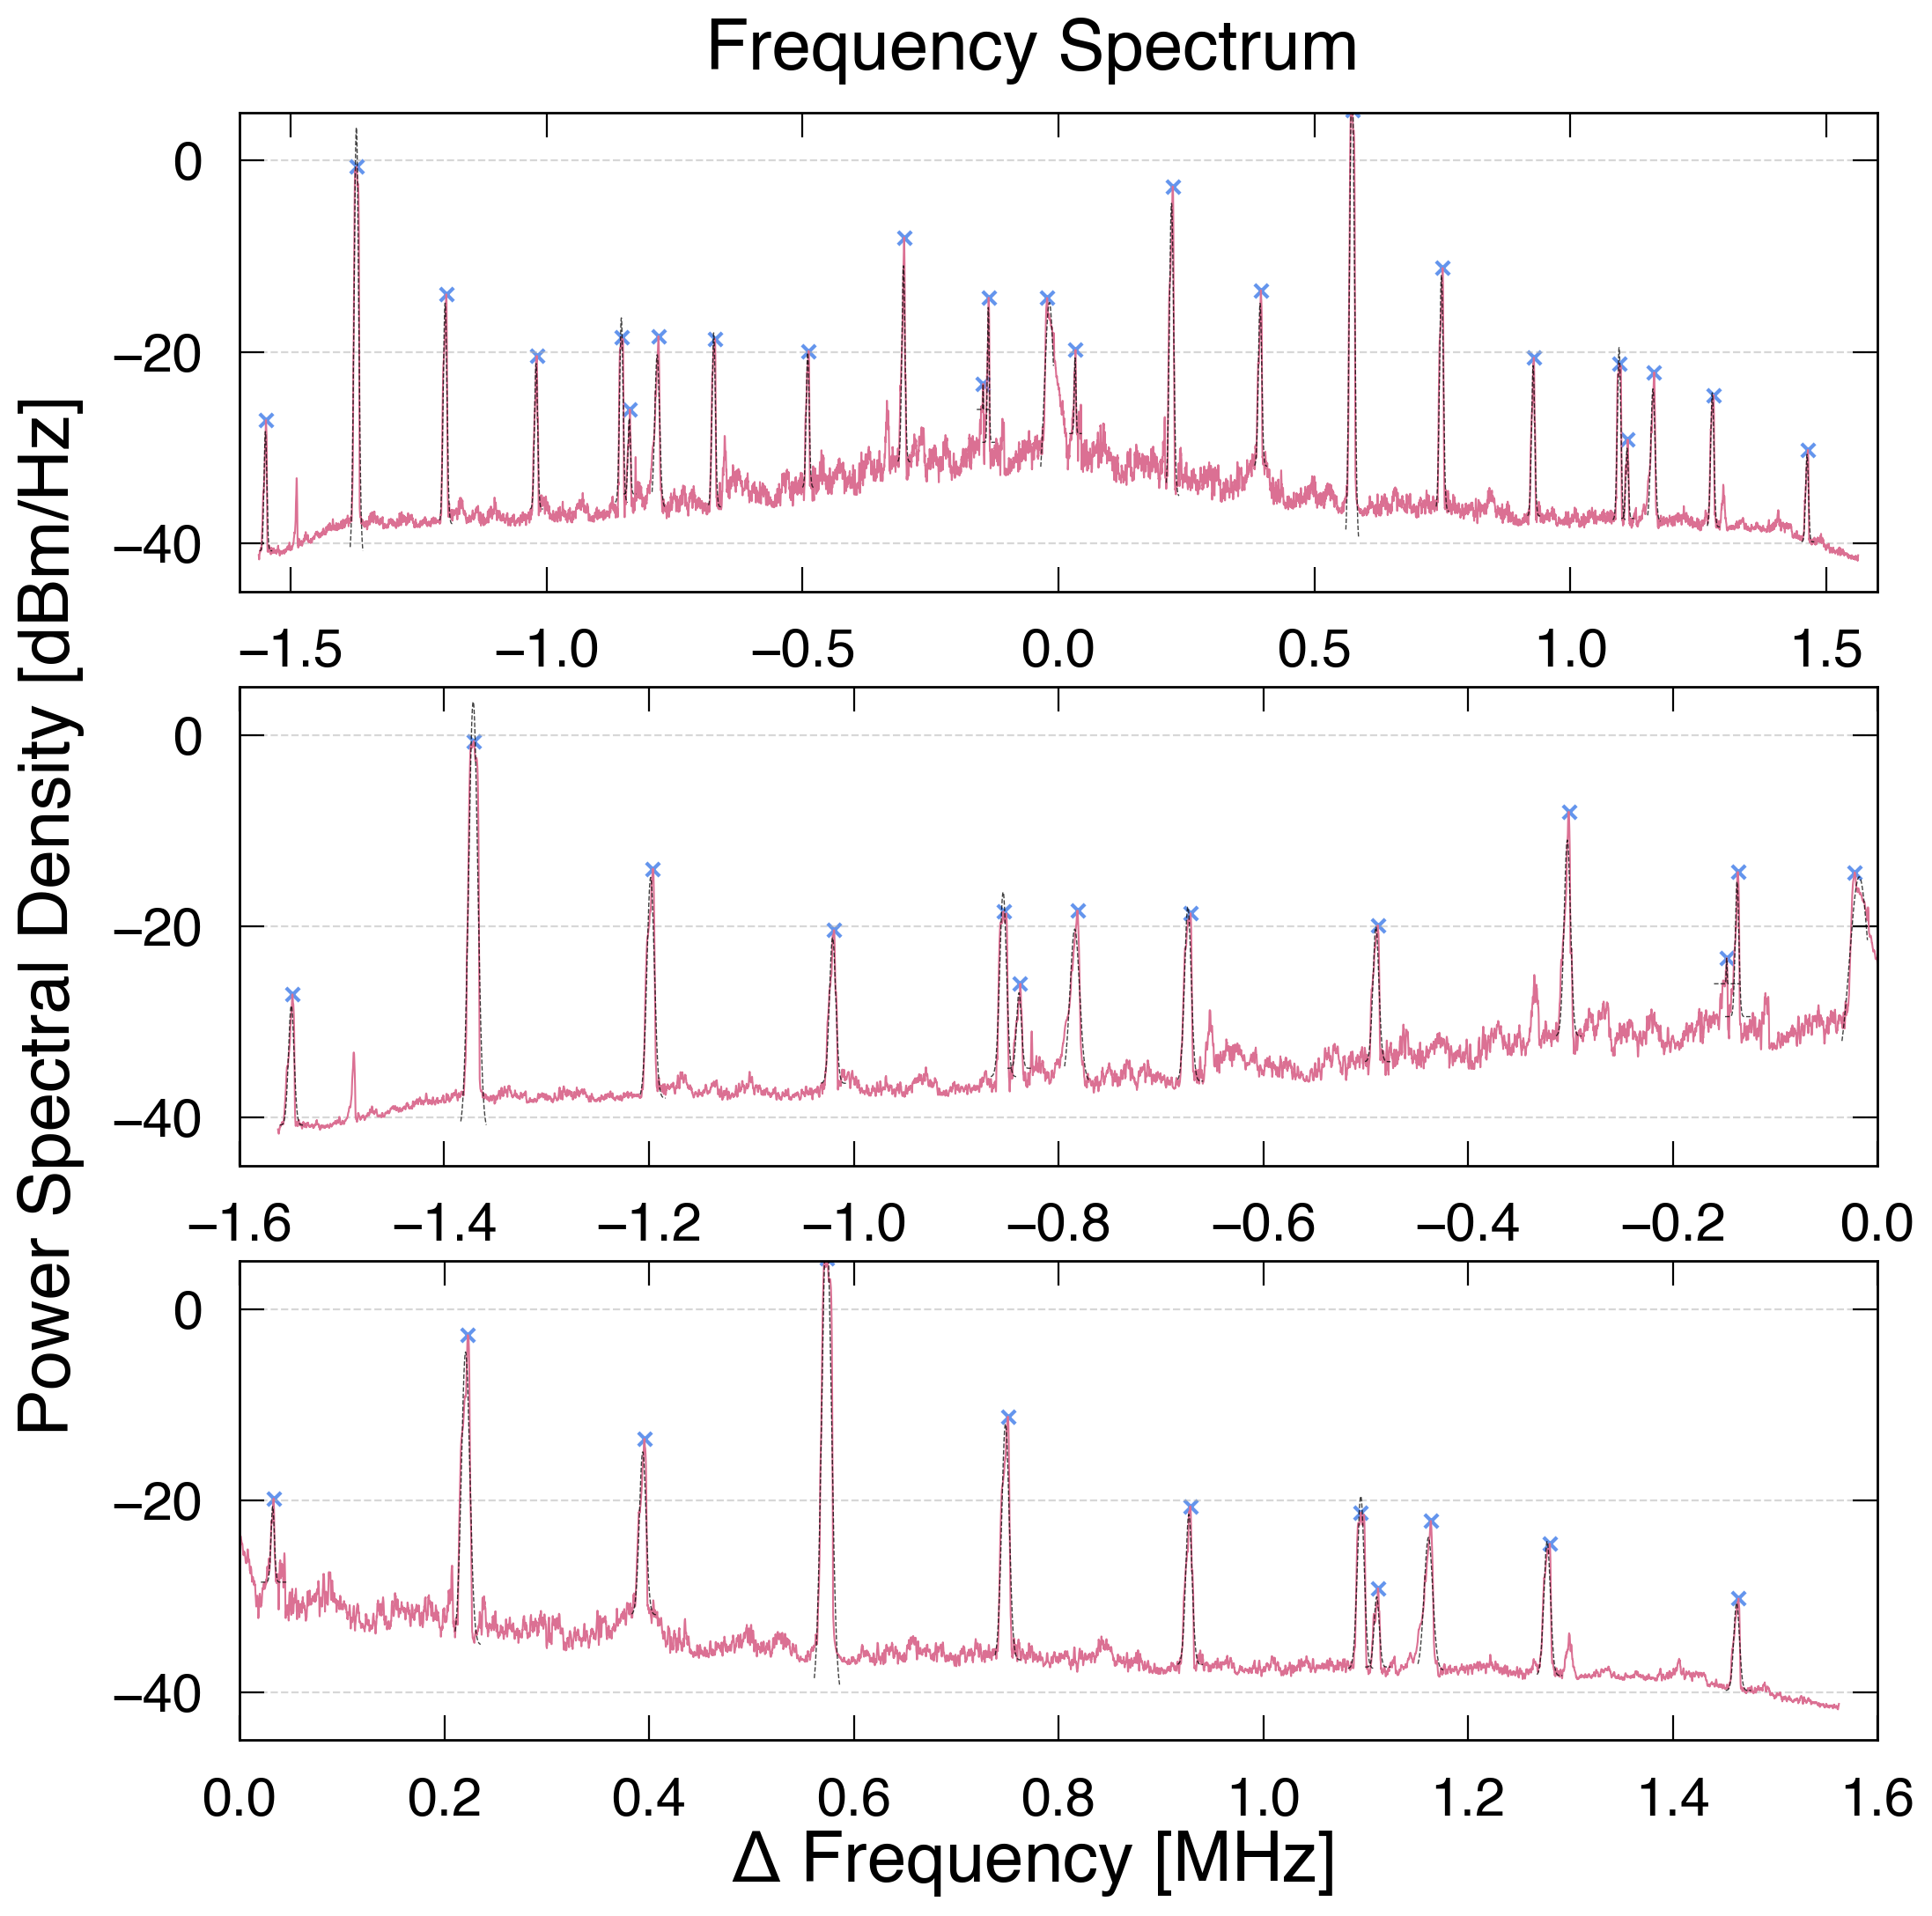

In [18]:
# figure
plt.style.use("/Users/gwgwhc/Documents/code/stylelib/ticksin_helvetica.mplstyle")
plt.rcParams["figure.dpi"] = 200
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# colours for plotting
colour_list = ["palevioletred", "palevioletred", "palevioletred"]

for i in range(len(ax)):
    # plot frequency spectrum
    ax[i].plot(
        freq_avg / 1e6, pwr_avg_dbm, color=colour_list[i], linestyle="-", linewidth=0.75
    )

    # plot found peaks
    ax[i].scatter(peak_pos / 1e6, peak_height, marker="x", s=30, color="cornflowerblue")

    # plot peak fit
    for j in range(len(peak_fits)):
        ax[i].plot(
            freq_avg[peak_bins[j] - fit_range : peak_bins[j] + fit_range] / 1e6,
            peak_fits[j][0],
            linestyle="--",
            linewidth=0.5,
            color="black",
            alpha=0.75,
            label="Fit",
        )


plt.suptitle("Frequency Spectrum", y=0.925)
fig.supxlabel("$\Delta$ Frequency [MHz]", y=0.035)
fig.supylabel("Power Spectral Density [dBm/Hz]")

# set axis range for each graph (full, neg side, pos side)
plt.setp((ax[0]), xlim=[-1.6, 1.6], ylim=[-45, 5])
plt.setp((ax[1]), xlim=[-1.6, 0], ylim=[-45, 5])
plt.setp((ax[2]), xlim=[0, 1.6], ylim=[-45, 5])

plt.show()

Hooray! Looks like we have some data! I had to play with the parameters a little to get some nice fitting, and even then its not perfect, so this is a fairly long process. But we're doing data analysis, so I assume you were already prepared for this.

Below is the same code but for looking at individual peaks without touching our data. This is a good way to check those that didn't fit properly.

In [19]:
# inspecting individual gaussian peaks
peak_index = 5  # select peak to plot
fit_range = 80  # fit range in bins

# single gaussian
result_check = gmodel.fit(
    pwr_avg_dbm[peak_bins[peak_index] - fit_range : peak_bins[peak_index] + fit_range],
    x=freq_avg[peak_bins[peak_index] - fit_range : peak_bins[peak_index] + fit_range],
    amp=15,
    cen=peak_pos[peak_index],
    sigma=2000,
    yoffset=-35,
)

fit_check(peak_index, result_check.redchi)

Peak  5 @ -0.84 MHz: Fit success!


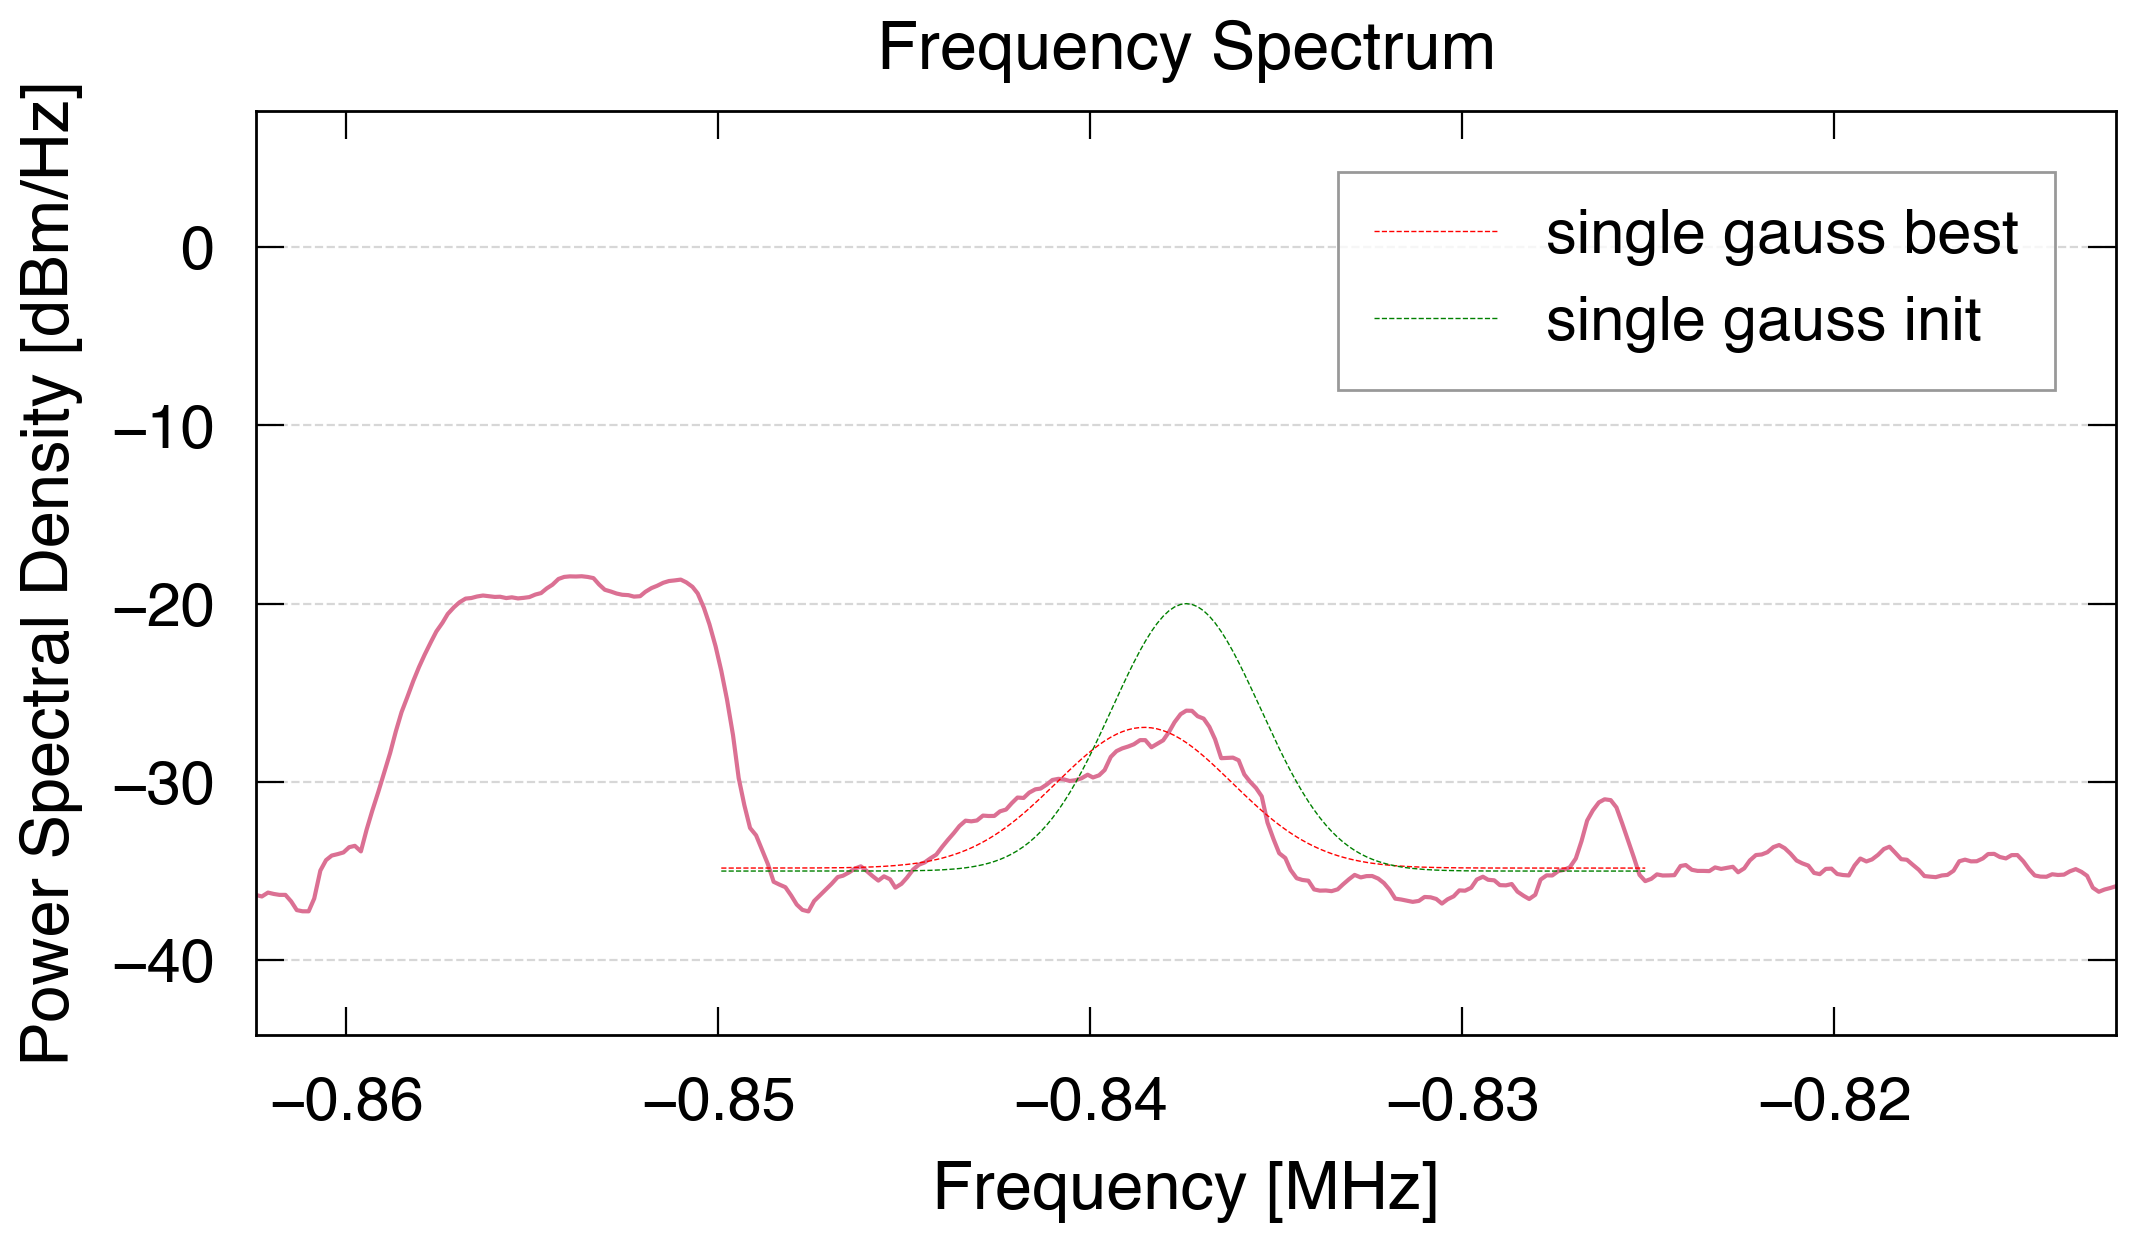

In [20]:
# zoomed frequency spectrum
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot frequency spectrum
ax.plot(
    freq_avg / 1e6,
    pwr_avg_dbm,
    color="palevioletred",
    # s=1)
    linestyle="-",
)

# # plot found peaks
# ax.scatter(peak_pos, peak_height,
#            marker='x',
#            color='cornflowerblue')

# single gauss initial
ax.plot(
    freq_avg[peak_bins[peak_index] - fit_range : peak_bins[peak_index] + fit_range]
    / 1e6,
    result_check.best_fit,
    linestyle="--",
    linewidth=0.5,
    color="red",
    label="single gauss best",
)
# single gauss best
ax.plot(
    freq_avg[peak_bins[peak_index] - fit_range : peak_bins[peak_index] + fit_range]
    / 1e6,
    result_check.init_fit,
    linestyle="--",
    linewidth=0.5,
    color="green",
    label="single gauss init",
)

ax.set_title("Frequency Spectrum", pad=15)
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Power Spectral Density [dBm/Hz]")

plot_range = 0.025  # +/- from the found peak center
plt.setp(
    (ax),
    xlim=[
        peak_pos[peak_index] / 1e6 - plot_range,
        peak_pos[peak_index] / 1e6 + plot_range,
    ],
)

plt.legend()
plt.show()

In [21]:
# fixing peak fits
overwrite_peak_fit = False
bad_peaks = [0]

# run until fixed all desired peaks
peak_index = 0
fit_range = 150  # fit range in bins

# result = gmodel.fit(pwr_avg[peak_bins[peak_index]-fit_range:peak_bins[peak_index]+fit_range],
#                     x=freq_avg[peak_bins[peak_index] -
#                                fit_range:peak_bins[peak_index]+fit_range],
#                     amp=5,
#                     cen=peak_pos[peak_index],
#                     sigma=2000,
#                     yoffset=-35)

# if overwrite_peak_fit == True:
#     peak_fits[peak_index] = [result.best_fit,
#                              result.params['cen'].value,
#                              result.params['sigma'].value,
#                              result.params['sigma'].stderr]

In [22]:
# new array of peaks without bad fits
peak_fits_new = [x for i, x in enumerate(peak_fits) if i not in bad_peaks]

# parameters to plot
peak_centers = np.array([peak_fits_new[i][1] for i in range(len(peak_fits_new))])
peak_stdev = np.array([peak_fits_new[i][2] for i in range(len(peak_fits_new))])
peak_sterr = np.array([peak_fits_new[i][3] for i in range(len(peak_fits_new))])

### Creating an Isochronicity Curve

In [23]:
# isochronous curve fit
def isochronous_fit(x, err_sys, gamma_t, sigma_mom):
    C_esr = 108.34
    gamma_i = 1 / np.sqrt(1 - (x * C_esr) ** 2 / c**2)
    return np.sqrt(
        ((1 / gamma_i**2 - 1 / gamma_t**2) * sigma_mom * x) ** 2 + (err_sys) ** 2
    )


iso_model = Model(isochronous_fit)
iso_result = iso_model.fit(
    x=peak_centers,
    data=peak_stdev,
    weights=1 / np.array(peak_sterr),
    err_sys=2000,
    gamma_t=1.4,
    sigma_mom=1e-2,
)
print(iso_result.fit_report())

[[Model]]
    Model(isochronous_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 23
    # variables        = 3
    chi-square         = 3433.42376
    reduced chi-square = 171.671188
    Akaike info crit   = 121.133837
    Bayesian info crit = 124.540320
    R-squared          = -0.09034325
[[Variables]]
    err_sys:    437.418652 +/- 1197.93815 (273.87%) (init = 2000)
    gamma_t:    1.38079264 +/- 0.20552981 (14.88%) (init = 1.4)
    sigma_mom:  0.00993144 +/- 0.00516015 (51.96%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma_t, sigma_mom) = -0.9654
    C(err_sys, sigma_mom) = -0.2270
    C(err_sys, gamma_t)   = +0.1128


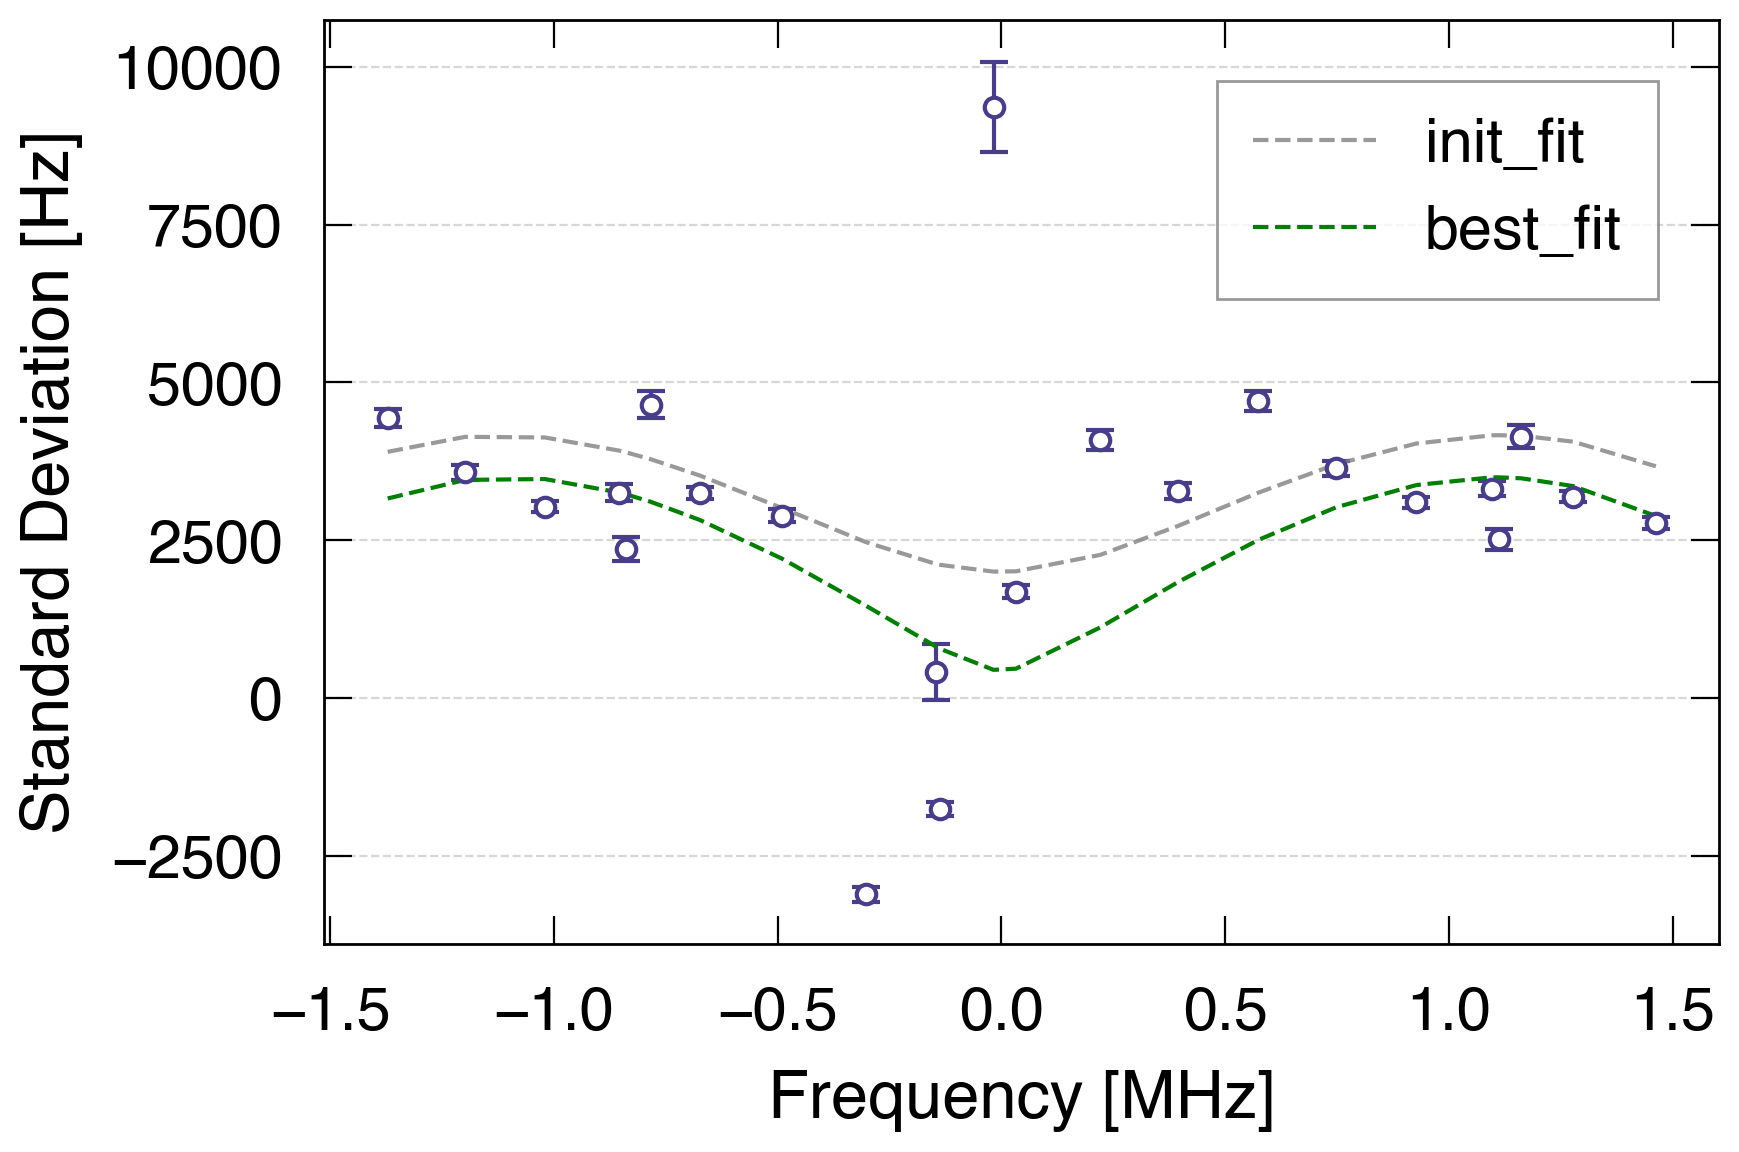

In [24]:
# isochronicity curve
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.errorbar(
    x=peak_centers / 1e6,
    y=peak_stdev,
    yerr=peak_sterr,
    fmt="o",
    markersize=7,
    capsize=5,
    color="darkslateblue",
    markerfacecolor="white",
)

ax.plot(
    peak_centers / 1e6,
    iso_result.init_fit,
    linestyle="--",
    color="grey",
    alpha=0.8,
    label="init_fit",
)

ax.plot(
    peak_centers / 1e6,
    iso_result.best_fit,
    linestyle="--",
    color="green",
    label="best_fit",
)

# ax.set_title('Isochronicity Curve', pad=15)
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Standard Deviation [Hz]")

plt.legend()
# plt.setp((ax), xlim=[-0.8, 0.8])
# plt.setp((ax), xlim=[-0.8, 0.8], ylim=[1000, 6000])
plt.show()
# plt.savefig(f'personal_directories/george/isochronous_curve.pdf',bbox_inches='tight')